In [ ]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import sympy

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

import random
from random import randint
import time

# Implementing your own Shazam

## **Getting your data!**

### Utility functions

In [ ]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
 

### Settings

In [ ]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 60 


data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")


### Preprocessing

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## **Fingerprint hashing**

### Read and preprocess titles


In [ ]:
titles=[]

# Title file of the song is opened and titles with capital letters 
# without backslashes are stored into preprocessed_titles list.

with open('data/mp3s-32k/all.list') as f:
    titles = f.readlines()
#Remove backslash, 1n, underscores from titles
preprocessed_titles = [str(x).replace('\n', '').replace('/', '-').replace('_', ' ').title() for x in titles]

### Read data and store peaks

In [ ]:
#Initialize list to store the peaks of all the songs
all_peaks=[]
# For each of the audio tracks, the peaks is extracted trough load_audio_picks()
# and stored into all_peaks list
for ind,audio in tqdm(enumerate(tracks)):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    all_peaks.append(peaks)

0it [00:00, ?it/s]

###**Sparse the peaks for each song**
Each of element of $\texttt{preprocessed_peaks}$ (i.e. the peak list of each song) is a dense vector, containing only the times at which a peak has been detected. We found out that the maximum value attained at the end of all the dense peak vector (i.e. the greatest time listened with a peak) is proportional to $\texttt{DURATION*44}$. Our aim is now to trasform those vector into 1-hot sparse vector: each of them will have a length proportional to the total duration of the song ($\texttt{DURATION*44}$), having at each time a 1 if a peak has been detected at that time, or a 0 if not. Since this representation result in a very sparse vector, this 0-1 condition can be relaxed binning adjacent times. We define a compression parameter $r$, equal to the number of adjacent times that we will bin together, keeping the 0-1 condition untouched. Turns out that $r=8$ is a good trade off between power of representation and sparsity reduction of the sparse vector. 

####E.G. 
$r=3$:
$$
\text{Uncompressed sparse vector}\hspace{1cm}\rightarrow\hspace{1cm}[\underline{0,0,0},\underline{0,1,0},\underline{1,1,1}]
$$
$$
\hspace{1cm}\Downarrow
$$
$$
\text{Compressed sparse vector}\hspace{1cm}\rightarrow\hspace{1cm}[0,1,1]
$$

In [ ]:
def peaks_onehot_trasform(all_peaks,DURATION,compression_rate):
  onehot_peaks=[]
  #Define original and compressed version lengths
  original_len=DURATION*44
  compressed_len=original_len//compression_rate+compression_rate

  #For all the songs extract its peak dense vector
  for song_peak in all_peaks:
    #Initialize a 1 hot vector proportional to the duration of the song
    onehot=np.zeros(compressed_len)
    #Read the element (i.e. the peak_position) of the dense vector
    #And initialize the element of the 1hot vector at index=peak_position to 1
    for peak_position in song_peak:
      onehot[peak_position//compression_rate]=1
    
    onehot_peaks.append(onehot)
    
  return(onehot_peaks)

In [ ]:
#Convert all song peaks into 1hot vectors
comp_rate=8
onehot_peaks=peaks_onehot_trasform(all_peaks,DURATION,compression_rate=comp_rate)

### **Song signature**
Now that a 1hot sparse vector for each song has been obtained, it will be used to produce a signature as follows: 

Repeat for $n=n_{permutation}$ times:

*   Perform a random shuffling over the elements of the 1hot vector;
*   Store the index of the first "1" element into the signature for the song;

The idea is that after several random permutation, comparing two signature vector (i.e. computing the percentage of equal elements between the vectors) will provide us of an estimator (that we will call $h(V_1,V_2)$) of the Jaccard Similarity between the two vectors. In particular, it can be proven that the $\mathbb{VAR}[h(V_1,V_2)]$ w.r.t. the $\text{J.S.}(V_1,V_2)$ shrink like $\frac{1}{4\cdot n}$. Using $n=200$ is finally a good tradeoff between consistency of the estimator and efficiency of the code.


In [ ]:
def signature(onehot_peaks,n_permutation):
  #Initialize list to store all the signature vectors for each song
  signature_mtrx=[]

  #For each of the onehot vectors, extract its signature and store it in the signature_matrix:
  for onehot_song in tqdm(onehot_peaks):
    
    #In order to perform the same shuffling to all the 1hot peak vectors
    #A random seed is initialized
    random.seed(4)
    signature_song=[]

    #Apply n_permutation to the 1hot vector, storing at each permutation
    #the index of the 1st "1" element into the signature
    for i in range(n_permutation):
      random.shuffle(onehot_song)
      signature_song.append(np.argmax(onehot_song>0))
    
    signature_song=np.array(signature_song)
    
    #Append each signature_song to the signature_matrix
    signature_mtrx.append(signature_song)
  
  return(np.array(signature_mtrx))

In [ ]:
#Define number of permutation to be executed into signature_matrix_maker
n_permutation=200

#Extract signature_matrix
signature_matrix=signature(onehot_peaks,n_permutation)

  0%|          | 0/1413 [00:00<?, ?it/s]

###**LSH: Bucketing**
Once signature matrix has been computed, we will divide it into bands each containing $b$ rows. By the construction of the permutation algorithm used to build the signature matrix and said $V$ the sparse representation for a general song, we know that each of the elements of the signature matrix is in the interval $\in [0,\text{len}(V)]$. Given a band value $b$ (i.e. the length of each band), a band can assume $\text{len}(V)^b$ different combinations. Because of this, through a simple hash function, we want each band (of each signature vector) to be hashed into an integer $\in [1,\text{len}(V)^b+1]$. The song index is then appended to the bucket corresponding hash-band value. Aim of this bucketing is to reduce the search of the best match once a query song is fed to the app: indeed, instead of searching the best match across all the songs in the dataset, we will search it only across the songs contained in the buckets where the bands of the query song have been hashed to. 

Said $x$ the band of a signature vector, and given $\alpha$ a vector of random integers $\in [1,M)$ s.t. $x \in \mathbb{N}^b,\alpha\in \mathbb{R}^b$, the hash integer $h(x,\alpha)$ is computed as follows:

$$
h(x,\alpha)=\left( \sum_i\alpha_i\cdot x_i \right) \text{mod} (M)
$$


The prime number $M$ used in the $\text{mod}$ operation has been chosen as the first prime greater than $\text{len}(V)^b$ since we want to be able to represent at least $\text{len}(V)^b$ combinations each band can assume.

The $b$ value has to be properly set: setting $b=n$ (recalling that $n=n_{\text{permutation}}$), each of the filled buckets will of course contain a single song. Since we want the user to be able to chose a similarity threshold (in order not to get just the exact match, but also similar songs to the input query), we want to lower the value of $b$ such to contain few similar songs in the same bucket of the query but keeping a good efficiency level which is the core reason of the LSH implementation. It heuristically turns out that $b=4$ accomplish those requirements. 




In [ ]:
#Define the function computing the hash having in input coefficients alpha, values x and the mod value
def hash(coefficient,values,mod):
  hash_key=(coefficient*values).sum()%mod
  return(hash_key)

In [ ]:
#Define a function to find the first prime greater than base^b
def find_mod(base,band):
  n=(base**band)
  while(True):
    n+=1
    if(sympy.isprime(n)):
      break
  print("Module value chosen for the hash is: ",n)
  return(n)

In [ ]:
#Define the length of each signature vector
signature_len=n_permutation

#Define the band value
b=4

#Initialize mod value and random coefficients for the hash function
mod=find_mod(len(onehot_peaks[1]),b)
random_coefficients=np.random.randint(1,mod-1,b)

#Build buckets through a dictionary initializing each key with an empty list
buckets={}
#for bucket in tqdm(range(mod)):
#  buckets[bucket]=[]

#For each song in the signature matrix: 
for song in tqdm(range(N_TRACKS)):
  #Each signature vector is divided into signature_len//b bands
  for col in range(signature_len//b-1):
    band=signature_matrix[song,col*b:(col+1)*b]
    #Once the band is selected, its hash value is computed
    key=hash(random_coefficients,band,mod)
    
    #The song is appended to the corresponding bucket
    if key in buckets:
      buckets[key].append(song)
    else:
      buckets[key]=[]
      buckets[key].append(song)

Module value chosen for the hash is:  13051691563


  0%|          | 0/1413 [00:00<?, ?it/s]

###Test query songs
We are now going to feed each of the query songs into the same process:

1.   Extract the dense vector of peaks through $\texttt{load_audio_picks()}$;
2.   Trasform the dense vector of peaks into its sparse one hot representation;
3.   Convert the one hot sparse representation into a signature through the permutation algorithm;

After the computation of the signature vector for each query song, the following steps are taken to find the best dataset song match according to our $\text{THRESHOLD}$ value:

4.   For each of the bands in the signature vector, compute its hash and store all the dataset songs contained in the corresponding bucket;
5.   Store the dataset song having the best similarity value (i.e. percentage of identical shared element with the query song), considering that we are now using the $\text{THRESHOLD}$ to upper bound the similarity value (better explanations in code comments);

In [ ]:
#Define a glob.glob sorting criteria to read query songs in order
def sortKeyFunc(s):
    return int(os.path.basename(s)[5:-4])

In [ ]:
#Read the query tracks
query_folder = Path("query/")
query_tracks = sorted(query_folder.glob("*.wav"), key=sortKeyFunc)


In [ ]:
#For each of the query song, extrack the dense peak vectors through load_audio_picks()
#and store it into query_peaks list
query_peaks=[]
for ind,audio in tqdm(enumerate(query_tracks)):
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    query_peaks.append(peaks)

0it [00:00, ?it/s]

In [ ]:
#Trasform the dense peak vectors into one hot sparse vectors
query_onehot=peaks_onehot_trasform(query_peaks,DURATION,compression_rate=comp_rate)

In [ ]:
#Extract the signature_matrix for the query songs
query_signature_matrix=signature(query_onehot,n_permutation)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def best_matches(signature_matrix,query_signature_matrix,b,random_coefficients,mod,signature_len,THRESHOLD):
  
  #Define the number of query songs
  n_query_songs=10

  #For each of the query songs:
  for query_song in range(n_query_songs):
    #Each query signature vector is divided into signature_len//b bands
    for col in range(signature_len//b-1):
      band=query_signature_matrix[query_song,col*b:(col+1)*b]
      #Once the band is selected, its hash value is computed
      key=hash(random_coefficients,band,mod)

      #We can now identify at wich bucket the query song band is mapped:
      #All the dataset songs in the same bucket are stored in the similarity list
      similarity=[]
      for song_in_query_bucket in buckets[key]:
        similarity.append(song_in_query_bucket)
    
    #Trasform the similarity list into a set to remove duplicate dataset songs
    similarity_set=set(similarity)
    best_similarity=0
    best_match=0
    
    #For each of the dataset songs in the similarity set, a similarity_value to the query is computed
    #(i.e. the percentage of identical element between the dataset song signature and the query signature)
    for dataset_song in similarity_set:
      similarity_value=(query_signature_matrix[query_song]==signature_matrix[dataset_song]).sum()/signature_len

      #If this similarity_value is better than the actual best_similarity and lower than our threshold,
      #best similarity is updated and the dataset_song is saved as the best_match 
      if(similarity_value>best_similarity and similarity_value<=THRESHOLD ):
        best_similarity=similarity_value
        best_match=dataset_song
    #Print the best match if found
    if(best_similarity!=0):
      print("Best match for query song n.",query_song+1,"is:",preprocessed_titles[best_match],sep=" ")
    else:
      print("No match with similarity under treshold=",THRESHOLD,"found for query song n.",query_song+1,".",sep=" ")
    print("(Searched in buckets with a total of",len(similarity_set),"dataset songs.)\n",sep=" ")  


### **Threshold output test**
We compute and report results for several threshold values:

*   For THRESHOLD = 1, the dataset songs exactly matching the query songs are reported;
*   For THRESHOLD < 1, dataset songs similar to the query songs are reported;



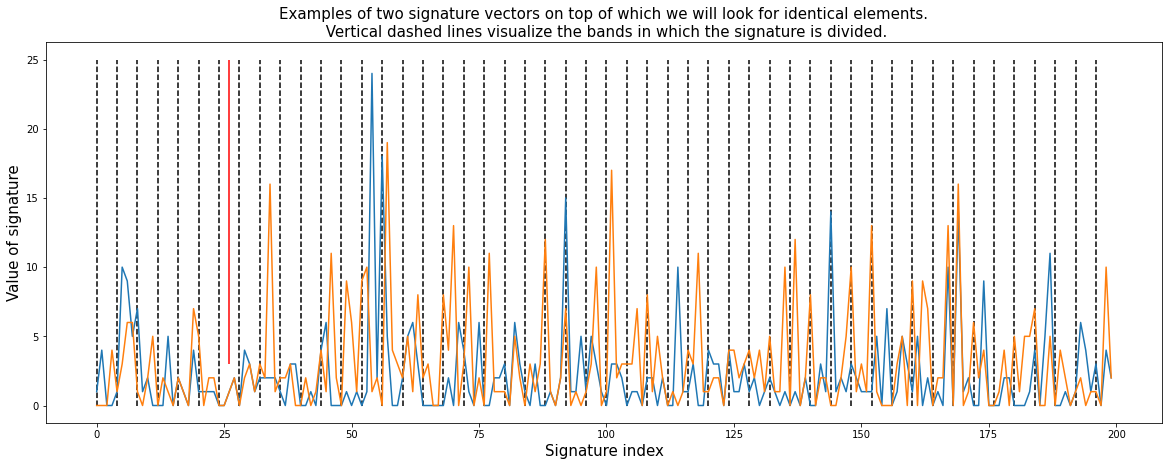

In [ ]:
bands=np.array(range(0,n_permutation,b))

plt.figure(figsize=(20,7))
plt.plot(signature_matrix[380])
plt.plot(query_signature_matrix[8])
plt.vlines(bands,0,25,linestyles="dashed")
plt.vlines(26,3,25,linestyles="solid",color="red")
plt.xlabel('Signature index',size=15)
plt.ylabel('Value of signature',size=15)
plt.title("Examples of two signature vectors on top of which we will look for identical elements.\n Vertical dashed lines visualize the bands in which the signature is divided.",size=15)
plt.show()

In the above example picture, a red vertical lineband is highlighting a band collision: two different songs, having an identical band, will be mapped in the same bin.

In [ ]:
THRESHOLD=1
best_matches(signature_matrix,query_signature_matrix,b,random_coefficients,mod,signature_len,THRESHOLD)

Best match for query song n. 1 is: Aerosmith-Aerosmith-03-Dream On
(Searched in buckets with a total of 4 dataset songs.)

Best match for query song n. 2 is: Queen-The Works-06-I Want To Break Free
(Searched in buckets with a total of 128 dataset songs.)

Best match for query song n. 3 is: U2-October-07-October
(Searched in buckets with a total of 2 dataset songs.)

Best match for query song n. 4 is: Beatles-The White Album Disc 1-04-Ob-La-Di Ob-La-Da
(Searched in buckets with a total of 377 dataset songs.)

Best match for query song n. 5 is: Radiohead-Ok Computer-06-Karma Police
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 6 is: Led Zeppelin-Led Zeppelin Ii-05-Heartbreaker
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 7 is: Fleetwood Mac-Rumours-05-Go Your Own Way
(Searched in buckets with a total of 189 dataset songs.)

Best match for query song n. 8 is: Green Day-American Idiot-01-American Idiot
(Search

In [ ]:
THRESHOLD=0.8
best_matches(signature_matrix,query_signature_matrix,b,random_coefficients,mod,signature_len,THRESHOLD)

Best match for query song n. 1 is: Madonna-Erotica-07-Waiting
(Searched in buckets with a total of 4 dataset songs.)

Best match for query song n. 2 is: Creedence Clearwater Revival-Green River-03-Tombstone Shadow
(Searched in buckets with a total of 128 dataset songs.)

Best match for query song n. 3 is: Queen-News Of The World-04-All Dead All Dead
(Searched in buckets with a total of 2 dataset songs.)

Best match for query song n. 4 is: Fleetwood Mac-Tusk-11-Angel
(Searched in buckets with a total of 377 dataset songs.)

Best match for query song n. 5 is: Steely Dan-Countdown To Ecstasy-01-Bodhisattva
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 6 is: Depeche Mode-Black Celebration-14-Black Day
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 7 is: Metallica-Load-06-Hero Of The Day
(Searched in buckets with a total of 189 dataset songs.)

Best match for query song n. 8 is: Led Zeppelin-Led Zeppelin Ii-08-Mo

In [ ]:
THRESHOLD=0.3
best_matches(signature_matrix,query_signature_matrix,b,random_coefficients,mod,signature_len,THRESHOLD)

Best match for query song n. 1 is: Madonna-Erotica-07-Waiting
(Searched in buckets with a total of 4 dataset songs.)

Best match for query song n. 2 is: Roxette-Have A Nice Day-04-Waiting For The Rain
(Searched in buckets with a total of 128 dataset songs.)

Best match for query song n. 3 is: Queen-News Of The World-04-All Dead All Dead
(Searched in buckets with a total of 2 dataset songs.)

Best match for query song n. 4 is: Aerosmith-Aerosmith-07-Movin Out
(Searched in buckets with a total of 377 dataset songs.)

Best match for query song n. 5 is: Steely Dan-Countdown To Ecstasy-01-Bodhisattva
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 6 is: Beatles-The White Album Disc 1-14-Don T Pass Me By
(Searched in buckets with a total of 10 dataset songs.)

Best match for query song n. 7 is: Led Zeppelin-Led Zeppelin Iii-06-Gallows Pole
(Searched in buckets with a total of 189 dataset songs.)

Best match for query song n. 8 is: Metallica-Load-05-King 